# mitransient quickstart: Cornell Box with diffuse boxes

## Overview
In this tutorial, you will render your very first **transient image** using `mitransient`!

<div class="admonition important alert alert-block alert-success">

🚀 **You will learn how to:**

<ul>
  <li>Import `mitransient`</li>
  <li>Setup and render a Cornell Box scene in the transient domain</li>
  <li>Visualize the output video</li>
</ul>

</div>

### Importing `mitransient`
Before importing `mitransient`, you need to import Mitsuba 3 and set a variant (here we use `llvm_ad_rgb`). Only if you want to use more variants, you will need to compile Mitsuba 3 (not `mitransient`) yourself. And you will need to add the compilation folder to the `PYTHONPATH` (see the commented code for how to do that)

<div class="admonition important alert alert-block alert-warning">

For many cases, `mitransient` requires the use of a `llvm_*` or `cuda_*` variant, so we don't recommend using `scalar_rgb`. It will work with any `llvm_*` or `cuda_*` variant, and for most use cases `llvm_ad_rgb` or `cuda_ad_rgb` is enough.

</div>

In [1]:
# If you have compiled Mitsuba 3 yourself, you will need to specify the path
# to the compilation folder
# import sys
# sys.path.insert(0, '<mitsuba-path>/mitsuba3/build/python')
import mitsuba as mi
# To set a variant, you need to have set it in the mitsuba.conf file
# https://mitsuba.readthedocs.io/en/latest/src/key_topics/variants.html
mi.set_variant('llvm_ad_mono_polarized')

import mitransient as mitr

import drjit as dr
# dr.set_flag(dr.JitFlag.SymbolicScope, False)
# dr.set_flag(dr.JitFlag.SymbolicCalls, False)
# dr.set_flag(dr.JitFlag.SymbolicLoops, False)
# dr.set_flag(dr.JitFlag.SymbolicConditionals, False)

[mitsuba] Warning: Couldn't import the ipywidgets package. Installing this package is required for the system to properly log messages and print in Jupyter notebooks!


We use the short alias `mitr` for `mitransient` for improved code readibility.

### Setup the Cornell Box scene

Scene data is represented using plugins. Each plugin can model geometry, materials, camera, lights, etc. Mitsuba 3 uses a XML format to represent the content of their scenes as a hierarchy of plugins (for example, the `sensor` plugin is a camera that contains a `film` plugin that stores the resulting image). You can check the `cbox_diffuse.xml` to see how it's structured. Concretely, `mitransient` provides new plugins that work in the transient domain such as `transient_path`, `transient_hdr_film`, etc.

Here we use the `mi.load_file` function, which takes a XML file path as input. But you can also use `mi.load_dict`, which takes a Python dictionary object. Choose whatever is easier for you. We provide a `mitr.cornell_box()` function which can be used to load a Cornell Box like the one in this example: `mi.load_dict(mitr.cornell_box())`

In [2]:
# Load XML file
# You can also use mi.load_dict and pass a Python dict object
# but it is probably much easier for your work to use XML files
import os
scene = mi.load_file(os.path.abspath('cornell-box/cbox_mirror.xml'))

The only difference with a conventional (steady state) scene is that a transient scene must use a [transient integrator](https://mitransient.readthedocs.io/en/latest/generated/plugin_reference/section_integrators.html#integrators) and a [transient film](https://mitransient.readthedocs.io/en/latest/generated/plugin_reference/section_films.html#films).

### Render the scene in steady and transient domain

<div class="admonition important alert alert-block alert-warning">
Mitsuba 3 and `mitransient` work with Dr.JIT, which has lazy evaluation.
That means the actual image/video will not be computed until you use it.
As such, this cell should take &lt;1s to execute
</div>

In [3]:
data_steady, data_transient = mi.render(scene, spp=4096)

Channels ['0', '1', '2', '3', 'W']


In [4]:
print(data_steady.shape, data_transient.shape)

(400, 400, 1) (400, 400, 400, 4)


The result is:
1) A steady state image `data_steady` with dimensions (width, height, channels)
2) A transient image `data_transient` with dimensions (width, height, time, channels)

`data_steady` would be the result of a conventional (non-transient) render i.e. `data_steady = data_transient.sum(axis=2)`

### Visualize the steady and transient image
We provide different functions so you can visualize your data in a Jupyter notebook

In [5]:
# Plot the computed steady image
mi.util.convert_to_bitmap(data_steady)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [400, 400],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 469 KiB of image data ]
]

<div class="admonition important alert alert-block alert-warning">
You will see that the `show_video` function takes some seconds to execute.
In reality most of this time is spent rendering the transient image, as was explained before.
</div>

In [6]:
# Plot the computed transient image as a video
data_transient_tonemapped = mitr.vis.tonemap_transient(data_transient, normalize_M00=False)

# mitr.vis.show_video(
#     data_transient_tonemapped,
#     axis_video=2,
# )

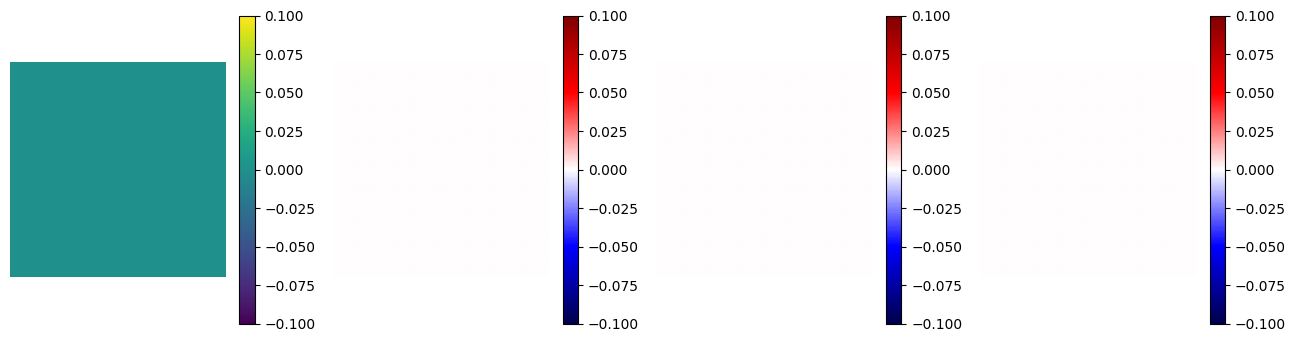

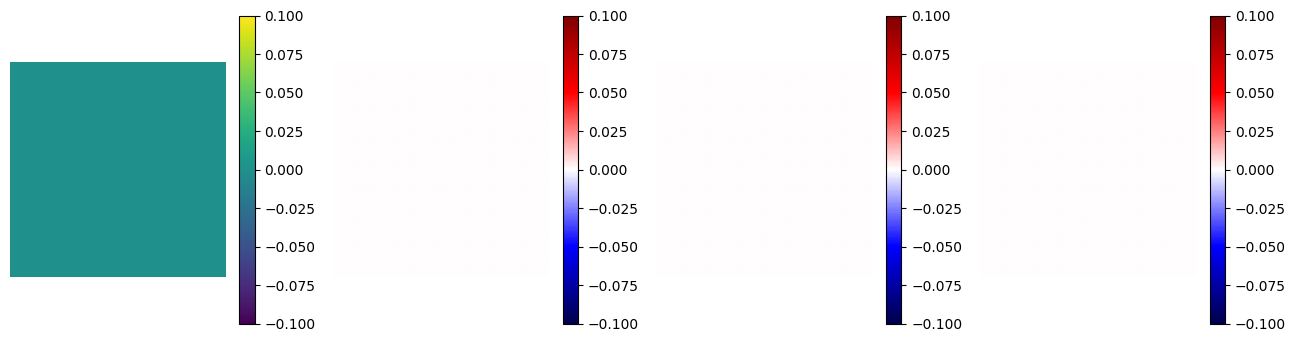

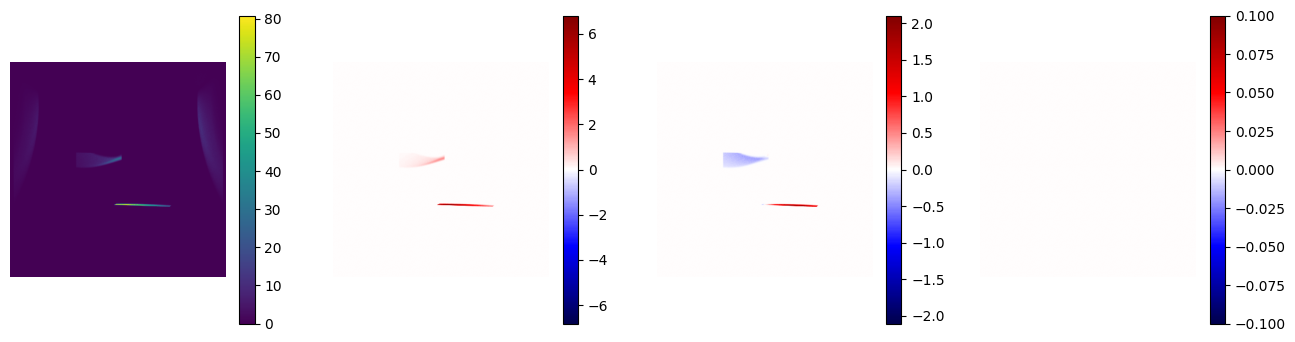

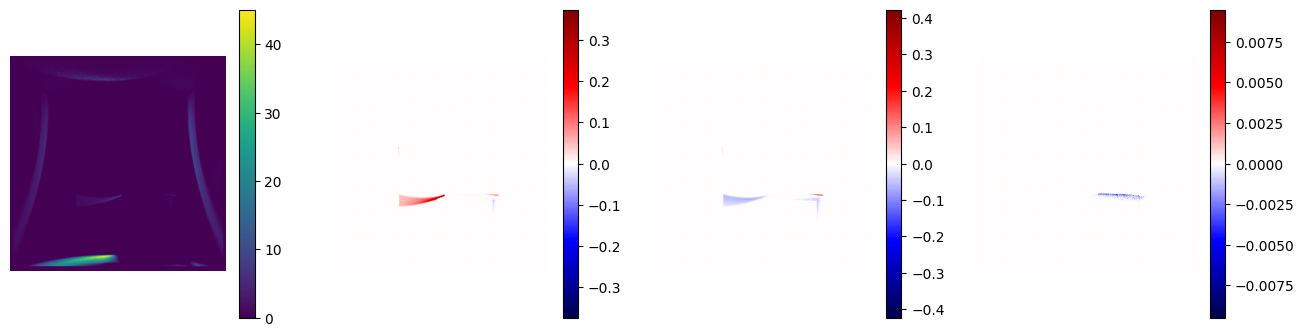

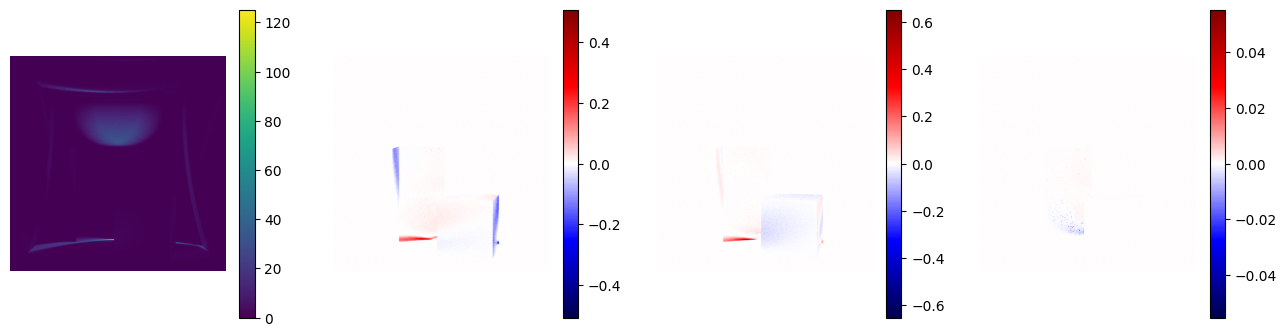

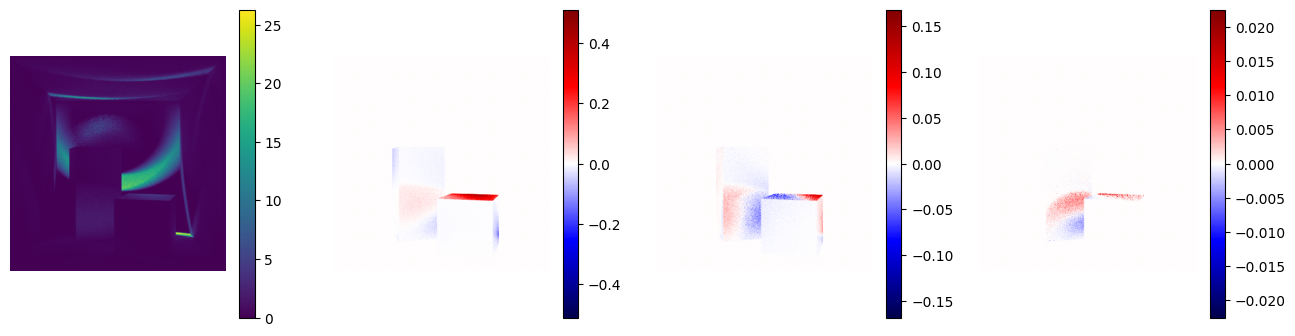

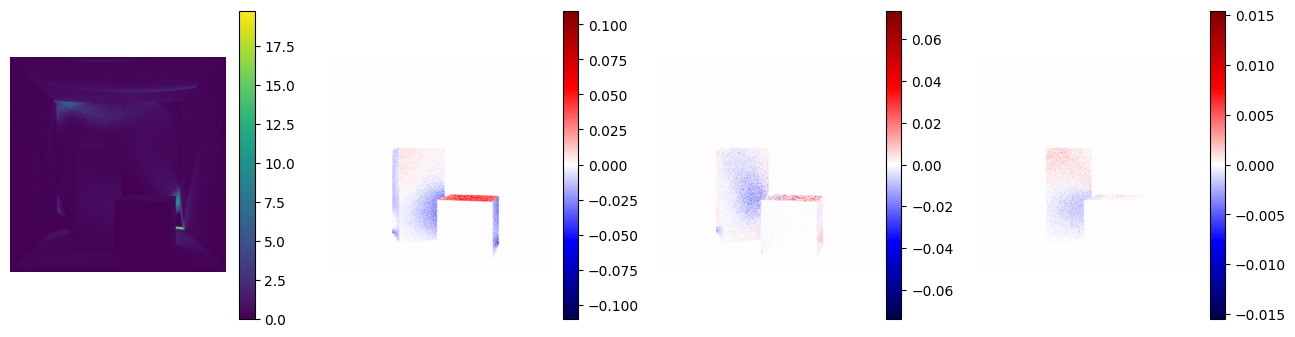

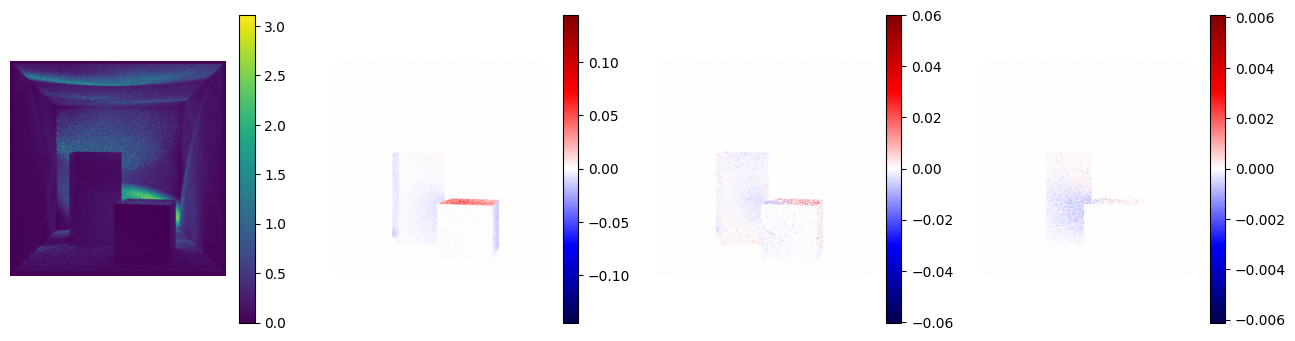

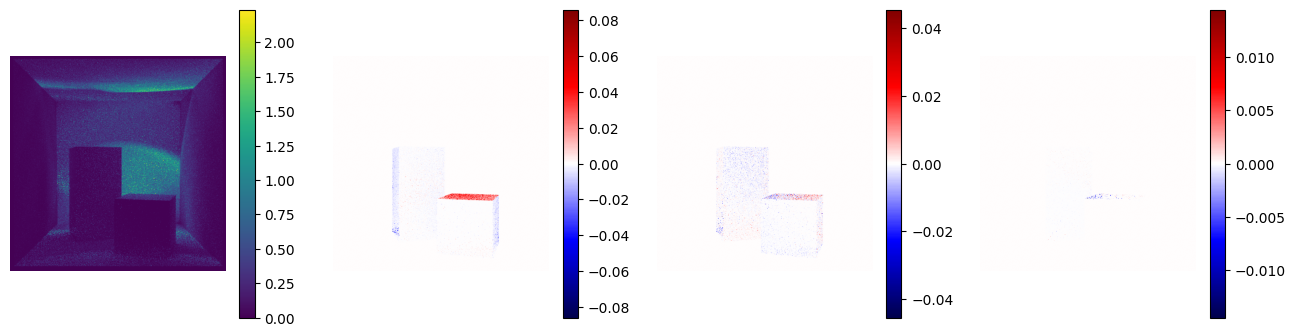

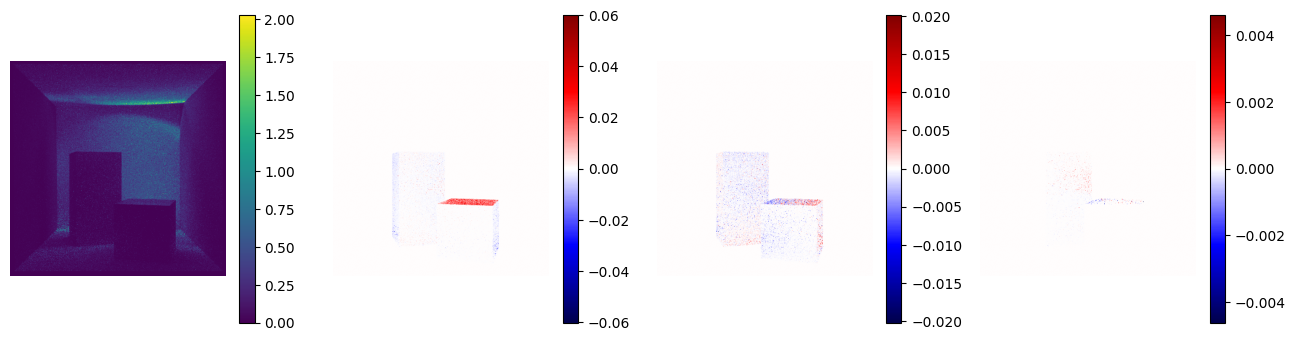

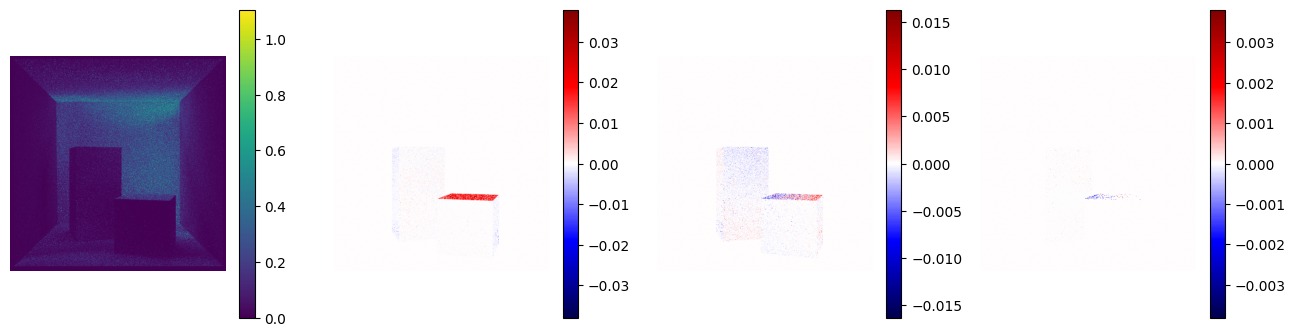

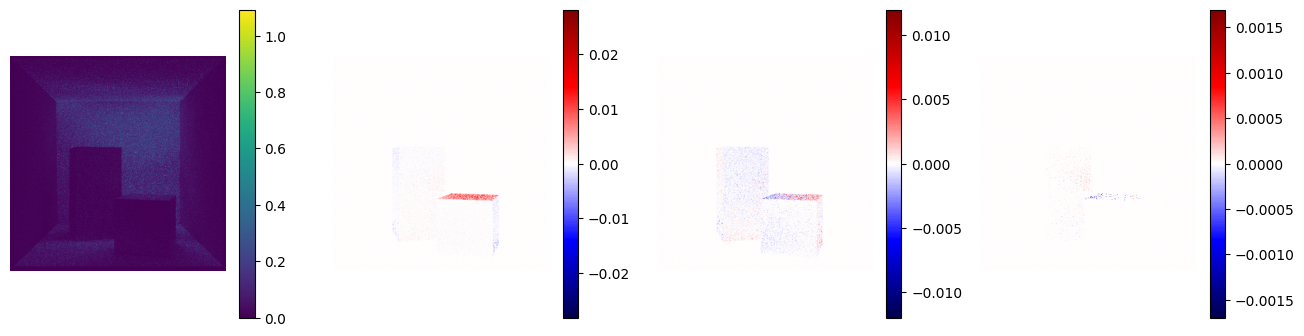

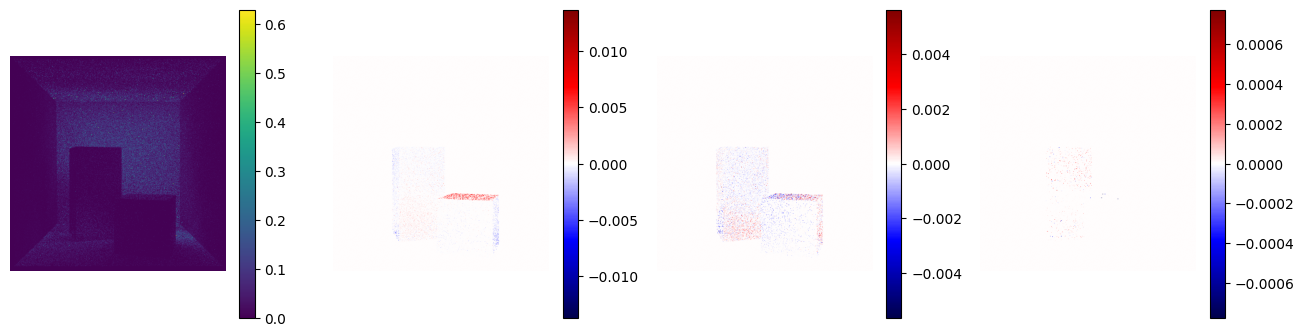

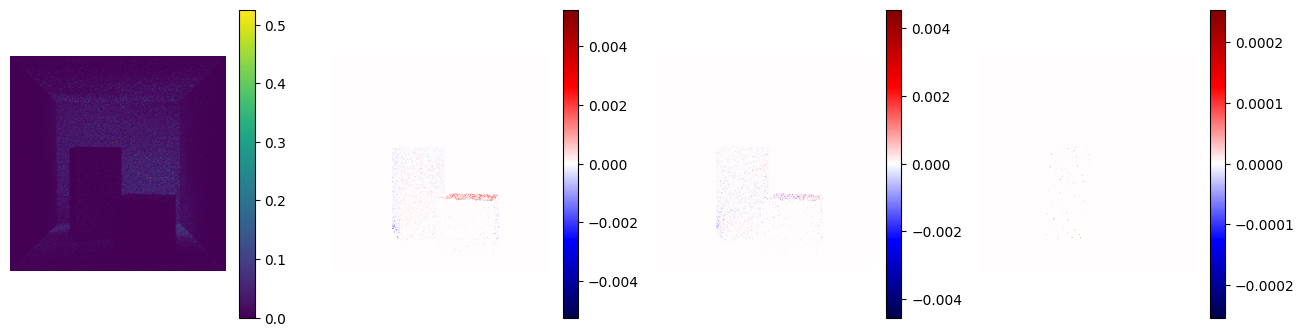

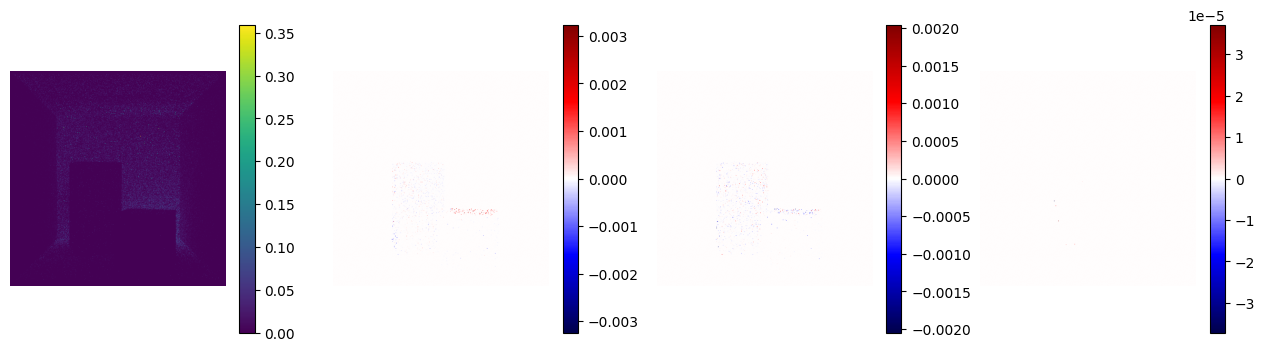

In [7]:
# Plot some frames of the computed transient image
import numpy as np
import matplotlib.pyplot as plt
def pol_imshow(x, gamma=1.0):
    vm = max(abs(np.min(x)), abs(np.max(x)))
    # print(vm)
    # s = np.sign(x)
    # xt = s * (np.abs(x) ** (1 / gamma))
    return plt.imshow(x, cmap='seismic', vmin=-vm, vmax=vm)

data_transient = np.array(data_transient_tonemapped)
# data_transient_tonemapped = np.array(data_transient_tonemapped)

tbins = range(0, 375, 25)
# data_transient_tonemapped[data_transient_tonemapped > 1] = 1

for tb in tbins:
    plt.figure(figsize=(16,4))
    plt.subplot(141)
    plt.axis("off")
    im = plt.imshow(data_transient[:, :, tb, 0], vmin=0)
    plt.colorbar(im)
    plt.subplot(142)
    plt.axis("off")
    im = pol_imshow(data_transient[:, :, tb, 1])
    plt.colorbar(im)
    plt.subplot(143)
    plt.axis("off")
    im = pol_imshow(data_transient[:, :, tb, 2])
    plt.colorbar(im)
    plt.subplot(144)
    plt.axis("off")
    im = pol_imshow(data_transient[:, :, tb, 3])
    plt.colorbar(im)

    plt.show()
